Using device: cuda
Initializing SiameseYOLOv8s with weights: yolov8s.pt
Successfully extracted backbone and head from yolov8s.pt. NC=80, reg_max=16
Detected backbone output channels: 32
모델 로드 성공! 에폭: 19, 손실: 1.2537
Detection output type: <class 'torch.Tensor'>
Output is a tensor with shape torch.Size([1, 64, 160, 160]) and dtype torch.float32


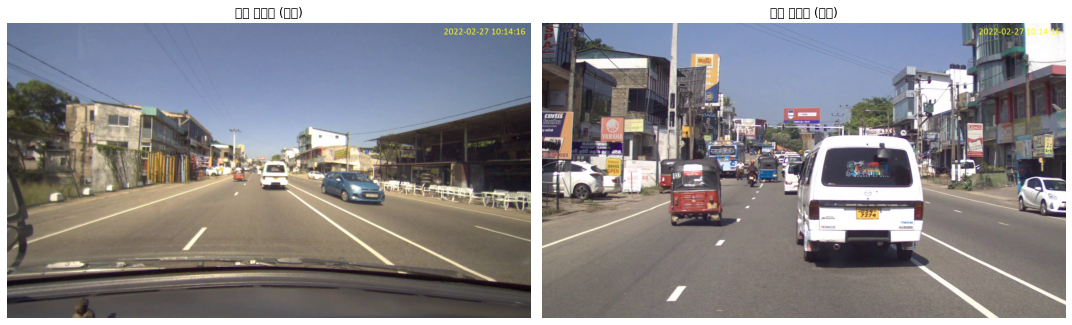

광각-협각 이미지 코사인 유사도: 1.0000


/home/byounggun/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/byounggun/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 52769 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/byounggun/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44208 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/byounggun/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44284 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/byounggun/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 50696 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/byounggun/anaconda3/lib/python3.9/site-packages/matplotlib/backend

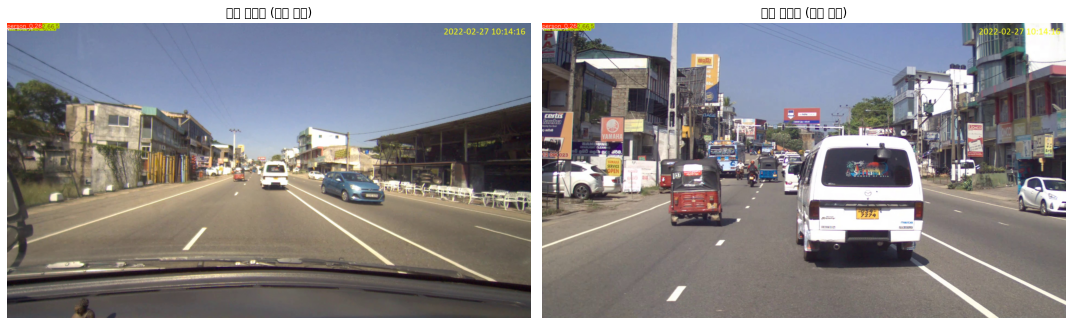

광각-협각 이미지 코사인 유사도: 1.0000


In [6]:
# 필요한 라이브러리 임포트
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from pathlib import Path

# 시스템 경로에 ultralytics 폴더 추가 (모듈을 찾을 수 있도록)
sys.path.append('/home/byounggun/ultralytics')

# 모델 및 유틸리티 임포트
from yolov8_siamese import SiameseYOLOv8s
from ultralytics.utils.plotting import Annotator, colors

# CUDA 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 모델 로드 함수
def load_siamese_model(weights_path, siamese_weights_path):
    """
    학습된 Siamese YOLOv8 모델을 로드합니다.
    
    Args:
        weights_path (str): YOLOv8 베이스 가중치 경로 (보통 'yolov8s.pt')
        siamese_weights_path (str): 학습된 Siamese 모델 가중치 경로
    
    Returns:
        model: 로드된 Siamese YOLOv8 모델
    """
    # 먼저 기본 구조 초기화
    model = SiameseYOLOv8s(yolo_weights_path=weights_path)
    
    # 학습된 가중치 로드
    ckpt = torch.load(siamese_weights_path, map_location=device)
    
    # train_siamese.py에서 저장한 체크포인트 구조에 맞게 로드
    if 'model_state_dict' in ckpt:
        model.load_state_dict(ckpt['model_state_dict'])
        print(f"모델 로드 성공! 에폭: {ckpt['epoch']}, 손실: {ckpt['loss']:.4f}")
    else:
        raise ValueError("체크포인트 파일 형식이 예상과 다릅니다. 'model_state_dict' 키가 없습니다.")
    
    model = model.to(device)
    model.eval()  # 평가 모드로 설정
    
    return model

# 이미지 로드 및 전처리 함수
def load_and_preprocess_image(image_path, img_size=640):
    """
    이미지를 로드하고 전처리합니다.
    
    Args:
        image_path (str): 이미지 파일 경로
        img_size (int): 이미지 크기 조정 값
    
    Returns:
        tuple: (원본 이미지, 전처리된 텐서)
    """
    # 이미지 로드
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 이미지 크기 및 비율 계산
    h, w = img.shape[:2]
    ratio = img_size / max(h, w)
    if ratio != 1:
        interp = cv2.INTER_LINEAR if ratio > 1 else cv2.INTER_AREA
        img_resized = cv2.resize(img, (int(w * ratio), int(h * ratio)), interpolation=interp)
    else:
        img_resized = img
    
    # 패딩 추가
    padded_h, padded_w = int(round(h * ratio)), int(round(w * ratio))
    padding = [(img_size - padded_h) // 2, (img_size - padded_w) // 2]
    img_padded = np.full((img_size, img_size, 3), 114, dtype=np.uint8)
    img_padded[padding[0]:padding[0] + padded_h, padding[1]:padding[1] + padded_w] = img_resized
    
    # 텐서로 변환 및 정규화
    img_tensor = torch.from_numpy(img_padded).permute(2, 0, 1).float().div(255.0).unsqueeze(0)
    
    return img, img_tensor

# 예측 결과 시각화 함수
def visualize_predictions(img, predictions, names, conf_threshold=0.25):
    """
    객체 감지 예측 결과를 시각화합니다.
    
    Args:
        img (numpy.ndarray): 원본 이미지
        predictions (torch.Tensor): 모델의 예측 결과
        names (list): 클래스 이름 목록
        conf_threshold (float): 신뢰도 임계값
    
    Returns:
        numpy.ndarray: 바운딩 박스가 그려진 이미지
    """
    img_with_boxes = img.copy()
    h, w = img.shape[:2]
    
    # Annotator 초기화
    annotator = Annotator(img_with_boxes, line_width=2)
    
    if predictions.shape[0] > 0:
        # 신뢰도 기준으로 필터링
        predictions = predictions[predictions[:, 4] > conf_threshold]
        
        for det in predictions:
            x1, y1, x2, y2, conf, cls = det[:6]
            c = int(cls)
            label = f'{names[c]} {conf:.2f}'
            
            # 바운딩 박스 그리기
            annotator.box_label([x1, y1, x2, y2], label, color=colors(c, True))
    
    return annotator.result()

# 시암 특징 유사도 시각화 함수
def visualize_similarity(siamese_emb_wide, siamese_emb_narrow):
    """
    시암 네트워크의 특징 유사도를 시각화합니다.
    
    Args:
        siamese_emb_wide (torch.Tensor): 광각 이미지의 특징 임베딩
        siamese_emb_narrow (torch.Tensor): 협각 이미지의 특징 임베딩
    
    Returns:
        float: 코사인 유사도 점수
    """
    # 코사인 유사도 계산
    similarity = F.cosine_similarity(siamese_emb_wide, siamese_emb_narrow).item()
    
    return similarity

# 실행 함수
# 실행 함수
def run_inference(model, wide_img_path, narrow_img_path, conf_threshold=0.25):
    """
    Siamese YOLOv8 모델로 추론을 실행합니다.
    """
    # 이미지 로드 및 전처리
    wide_img_orig, wide_img_tensor = load_and_preprocess_image(wide_img_path)
    narrow_img_orig, narrow_img_tensor = load_and_preprocess_image(narrow_img_path)
    
    # 모델을 확실히 평가 모드로 설정
    model.eval()
    model.training = False
    
    # 모델 추론 실행
    with torch.no_grad():
        wide_img_tensor = wide_img_tensor.to(device)
        narrow_img_tensor = narrow_img_tensor.to(device)
        
        # 시암 네트워크의 forward 메소드에 두 이미지 전달
        feat_wide_tuple = model.shared_backbone(wide_img_tensor)
        feat_narrow_tuple = model.shared_backbone(narrow_img_tensor)
        
        # 시암 특징 추출
        siamese_emb_wide = model._extract_siamese_features(feat_wide_tuple)
        siamese_emb_narrow = model._extract_siamese_features(feat_narrow_tuple)
        
        # 객체 감지 예측
        detection_output = model.detection_head(feat_wide_tuple)
        
        # 출력 형식 확인 및 디버깅
        print(f"Detection output type: {type(detection_output)}")
        if isinstance(detection_output, (list, tuple)):
            print(f"Output is a {type(detection_output).__name__} of length {len(detection_output)}")
            for i, item in enumerate(detection_output):
                if torch.is_tensor(item):
                    print(f"Item {i} is a tensor with shape {item.shape} and dtype {item.dtype}")
                else:
                    print(f"Item {i} is a {type(item).__name__}")
        elif torch.is_tensor(detection_output):
            print(f"Output is a tensor with shape {detection_output.shape} and dtype {detection_output.dtype}")
        
        # 코사인 유사도 계산
        similarity = torch.nn.functional.cosine_similarity(
            siamese_emb_wide, siamese_emb_narrow
        ).item()
    
    # 이미지만 표시 (객체 감지 결과 없이)
    plt.figure(figsize=(15, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow(wide_img_orig)
    plt.title("광각 이미지 (원본)")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(narrow_img_orig)
    plt.title("협각 이미지 (원본)")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"광각-협각 이미지 코사인 유사도: {similarity:.4f}")
    
    return detection_output, similarity

# 기존 SiameseYOLOv8s 코드에 추론 전용 메서드 추가
def predict_with_siamese(self, x_wide, x_narrow):
    """
    추론을 위한 전용 메서드 - 바운딩 박스와 시암 유사도 반환
    """
    self.eval()  # 평가 모드 설정
    
    # 특징 추출
    feat_wide_tuple = self.shared_backbone(x_wide)
    feat_narrow_tuple = self.shared_backbone(x_narrow)
    
    # 시암 특징 추출
    siamese_emb_wide = self._extract_siamese_features(feat_wide_tuple)
    siamese_emb_narrow = self._extract_siamese_features(feat_narrow_tuple)
    
    # 유사도 계산
    similarity = F.cosine_similarity(siamese_emb_wide, siamese_emb_narrow)
    
    # YOLO 원시 출력
    raw_output = self.detection_head(feat_wide_tuple)
    
    # YOLO 출력을 후처리하여 바운딩 박스 얻기
    # 여기서는 ultralytics.utils.ops 모듈의 non_max_suppression 같은 함수 사용 가능
    from ultralytics.utils.ops import non_max_suppression
    
    # YOLOv8 원시 출력을 적절히 변환 (이 부분은 YOLOv8 버전과 구현에 따라 달라질 수 있음)
    # 예시: conf_thres=0.25, iou_thres=0.45로 NMS 적용
    detections = non_max_suppression(raw_output, conf_thres=0.25, iou_thres=0.45)
    
    return detections, similarity

# 모델 로드 및 추론 실행 예시
# 아래 경로를 실제 경로로 수정하세요
if __name__ == "__main__":
    # 경로 설정
    yolo_base_weights = "yolov8s.pt"  # YOLOv8 기본 가중치
    siamese_model_weights = "/home/byounggun/ultralytics/runs/my_siamese_training/experiment1/best.pt"  # 학습된 시암 모델 가중치
    
    # 테스트 이미지 경로
    wide_img_path = "/home/byounggun/ultralytics/traffics/wide_images_only/train/images/wide_t1_001.jpg"
    narrow_img_path = "/home/byounggun/ultralytics/traffics/narrow_images_only/train/images/narrow_t1_001.jpg"
    
    # 모델 로드
    model = load_siamese_model(yolo_base_weights, siamese_model_weights)
    
    # 추론 실행
    predictions, similarity = run_inference(model, wide_img_path, narrow_img_path)

    # 시각화
    wide_img_orig, wide_img_tensor = load_and_preprocess_image(wide_img_path)
    narrow_img_orig, narrow_img_tensor = load_and_preprocess_image(narrow_img_path)
    
    # 예측 결과 시각화
    wide_img_with_boxes = visualize_predictions(wide_img_orig, predictions[0], model.names)
    narrow_img_with_boxes = visualize_predictions(narrow_img_orig, predictions[0], model.names)
    
    # 결과 이미지 표시
    plt.figure(figsize=(15, 10))
    
    plt.subplot(1, 2, 1)
    plt.imshow(wide_img_with_boxes)
    plt.title("광각 이미지 (예측 결과)")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(narrow_img_with_boxes)
    plt.title("협각 이미지 (예측 결과)")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"광각-협각 이미지 코사인 유사도: {similarity:.4f}")